# What is Recurrent Neural Networks(RNN)?

If we want to predict the next word in a sequence, we'd better know which words are in front of it. The RNN is circular because it performs the same operation for each element in the sequence. Each operation depends on the previous state of the calculation. Think of it in a different way. It can be assumed that the RNN has already remembered the information calculated until now.

![](https://imgur.com/B04E6t1.png)

In order to make the concept of these loops and states clearer, we use Numpy to implement a simple RNN. Suppose our RNN needs to accept a "sequence of vectors" as an input, and this "sequence of vectors" is represented as a two-dimensional tensor (timesteps, input_features).

Our RNN will iterate over every "timestep" and then we will use "t" to mean "timestep." The input of a particular "time step (t)" is "X" (input_feature)

## A simple RNN pseudo-code:
```
# This is the internal state of a certain "timestep"
state_t = 0 
for input_t in input_sequence:
    output_t = f(input_t, state_t)
    
    # The previously processed output becomes a new state
    state_t = output_t 
    ```

We can further subdivide the contents of the "f" function:
> The "f" function: used to convert input and state to output. This function is parameterized by two matrices W and U and a bias.

## A simple RNN more detailed pseudo-code:
```
state_t = 0 
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t 
    ```
    
## A simple RNN implemented with Numpy
```
timesteps = 100 # The number of time steps in the input sequence
input_features = 32 # The dimension of the input feature space
output_features = 64 # The dimension of the output feature space

# input data
inputs = np.random.random((timesteps, input_features))

# "initial state": an all-zero vector
state_t = np.zeros((output_features,))

# Create a random weight matrix
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs: 
    # We combine the input with the current state (the previous output) to obtain the current output.
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)

    # We store this output in a list.
    successive_outputs.append(output_t)

    # We update the network "state" of the next time step
    state_t = output_t

# The final output is 2D tensor (timesteps, output_features)
final_output_sequence = np.concatenate(successive_outputs, axis=0)
```

![](https://imgur.com/HU65c0w.png)

## A first recurrent layer in Keras
The process we just naively implemented in Numpy corresponds to an actual Keras layer: the SimpleRNN layer:

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.2'

In [2]:
from keras.layers import SimpleRNN

There is just one minor difference: SimpleRNN processes batches of sequences, like all other Keras layers, not just a single sequence like in our Numpy example. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, input_features).`

Like all recurrent layers in Keras, SimpleRNN can be run in two different modes: it can return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features))`, or it can return only the last output for each input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor argument. Let's take a look at an example:

### Use SimpleRNN and return to the last state
`return_sequences` defaults to `False`
![](https://imgur.com/KAtwXV6.png)

In [3]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32)) # return_sequences defaults to False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


### Use SimpleRNN and return the complete state sequence
Set `return_sequences` to `True`
![](https://imgur.com/niNFXit.png)

In [4]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True)) # Set return_sequences to True
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


### Stack multiple RNN layers together

It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. In such a setup, you have to get all intermediate layers to return full sequences:
![](https://imgur.com/g04Ny5X.png)

In [5]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [6]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an Embedding layer and a SimpleRNN layer:

In [9]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 33s 2ms/step - loss: 0.5649 - acc: 0.7116 - val_loss: 0.4154 - val_acc: 0.8422
Epoch 2/10
20000/20000 [==============================] - 34s 2ms/step - loss: 0.3403 - acc: 0.8660 - val_loss: 0.4315 - val_acc: 0.8312
Epoch 3/10
20000/20000 [==============================] - 32s 2ms/step - loss

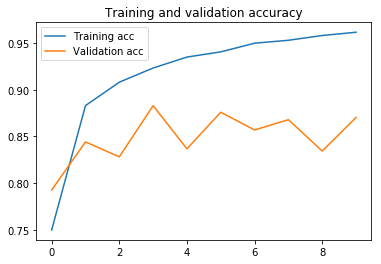

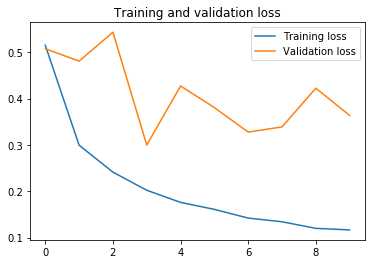

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Unfortunately, our small recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is that our inputs only consider the first 500 words rather the full sequences -- hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that SimpleRNN isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some more advanced layers.

## Learn about long short-term memory (LSTM) and GRU
SimpleRNN is not the only available RNN layer for Keras: there are LSTM and GRU in Keras. In practice, you will always use one of them. SimpleRNN is generally too simple to use for any practical purpose.

The LSTM (long short-term memory cell) uses input gates to forget the forget and output gates to resolve the phenomenon of gradient vanishing  or gradient exploding that the original RNN cell would face. 

![](https://imgur.com/Sn93XUl.png)
Each of these gates has its own set of weight values. The entire LSTM cell is differential (meaning we calculate gradients and use them to update weights), so we can iteratively train it using back-propagation. Basically, LSTM units provide us with mechanisms for forget, memory and attention.
![](https://imgur.com/rEaka4u.png)

## A concrete LSTM example in Keras
Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, similar to the one with SimpleRNN that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you having to spend time tuning parameters by hand.

In [10]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 144s 7ms/step - loss: 0.5152 - acc: 0.7499 - val_loss: 0.5077 - val_acc: 0.7926
Epoch 2/10
20000/20000 [==============================] - 143s 7ms/step - loss: 0.2994 - acc: 0.8831 - val_loss: 0.4810 - val_acc: 0.8442
Epoch 3/10
20000/20000 [==============================] - 133s 7ms/step - l

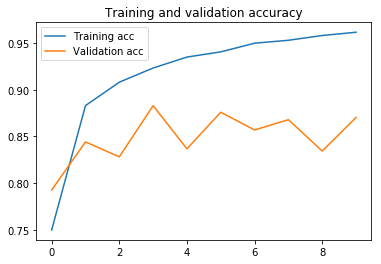

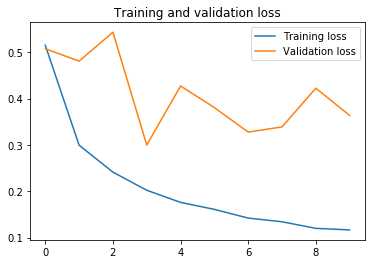

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Reference:
[fchollet: deep-learning-with-python-notebooks](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.2-understanding-recurrent-neural-networks.ipynb)